In [1]:
"""
Analysis of Stylophora single cell RNAseq data using ScanPy
Marc Meynadier
"""

'\nAnalysis of Stylophora single cell RNAseq data using ScanPy\nMarc Meynadier\n'

In [2]:
!date

Jeu 26 jan 2023 15:57:48 CET


In [3]:
import numpy as np
import anndata
import pandas as pd
import scanpy as sc
import scipy.sparse
import scanpy.external as sce

import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import (KNeighborsClassifier,NeighborhoodComponentsAnalysis)
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from matplotlib import rcParams
#import plotly.tools as tls

import seaborn as sns
sns.set(style="whitegrid")

import collections
import scipy.sparse as sp_sparse
import h5py

In [4]:
sc.logging.print_header()
sc.settings.set_figure_params(dpi=60, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.21.5 scipy==1.9.1 pandas==1.5.2 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.10.2 pynndescent==0.5.8


In [5]:
# Loading data

styPath = "../../../species/Stylophora/analysis/STARmapping/levy2021/GSE166901/GSM5087791/"
adata = sc.read_10x_mtx(styPath) ; adata.var_names_make_unique()

In [6]:
# Metadata
adata.obs['type']="All"
adata.obs['sample']="PPA" #Planula Polyp Adult

In [28]:
# Merging

In [7]:
# Mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('XLOC_MITO')
adata.var

,gene_ids,feature_types,mt
SpisGene22569,SpisGene22569,Gene Expression,False
SpisGene22566,SpisGene22566,Gene Expression,False
SpisGene22567,SpisGene22567,Gene Expression,False
SpisGene22568,SpisGene22568,Gene Expression,False
SpisGene22565,SpisGene22565,Gene Expression,False
...,...,...,...
SpisGene1339,SpisGene1339,Gene Expression,False
SpisGene1376,SpisGene1376,Gene Expression,False
SpisGene1449,SpisGene1449,Gene Expression,False
SpisGene1341,SpisGene1341,Gene Expression,False


In [8]:
# Mitochondrial quality check
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=True, inplace=True)
mito_genes = adata.var_names.str.startswith('XLOC_MITO')
# For each cell compute fraction of counts in mito genes vs. all genes
adata.obs['percent_mt2'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# Add the total counts per cell as observations-annotation 
adata.obs['n_counts'] = adata.X.sum(axis=1).A1
adata

AnnData object with n_obs × n_vars = 1201 × 25769
    obs: 'type', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'percent_mt2', 'n_counts'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

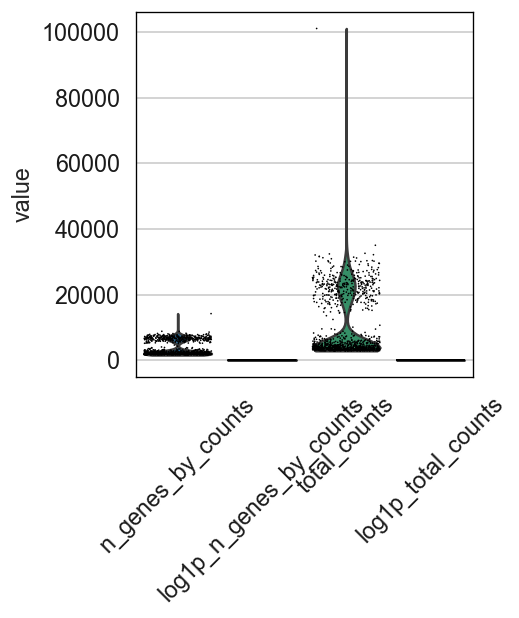

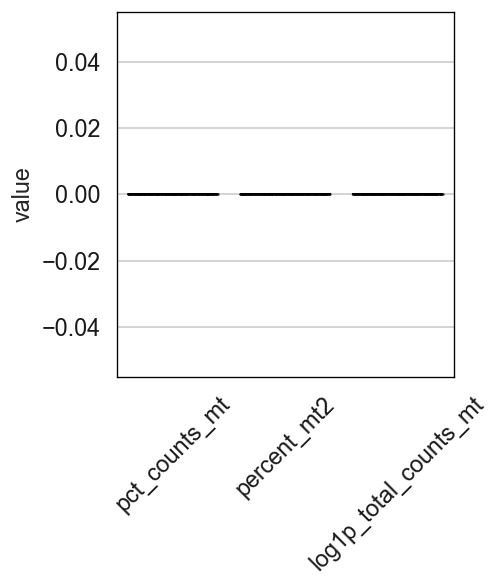

In [9]:
sc.pl.violin(adata, ['n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'],
             jitter=0.4, rotation= 45, ncols=2)
sc.pl.violin(adata, ['pct_counts_mt', 'percent_mt2','log1p_total_counts_mt'],
             jitter=0.4, rotation= 45, ncols=2)

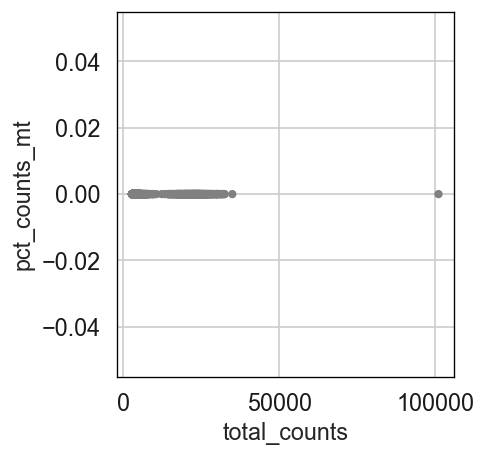

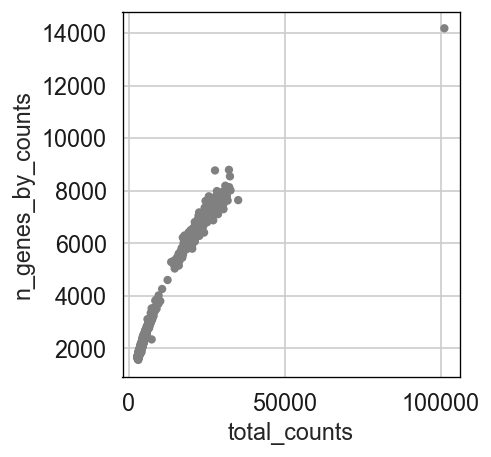

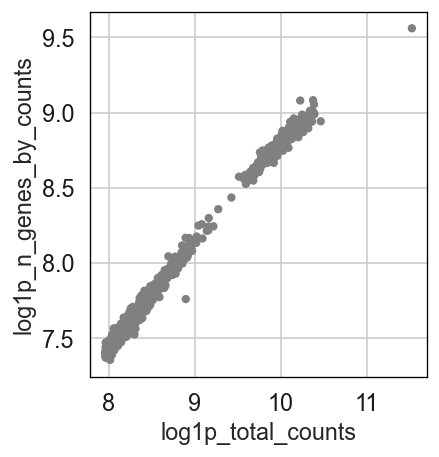

In [10]:
# Plot quality check measures
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')
sc.pl.scatter(adata, x='log1p_total_counts', y='log1p_n_genes_by_counts')

In [11]:
# Filtering by genes counts and mitochrondial genes counts
adata = adata[adata.obs.n_genes_by_counts < 9000, :]
adata = adata[adata.obs.pct_counts_mt < 1, :]
adata

View of AnnData object with n_obs × n_vars = 1200 × 25769
    obs: 'type', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'percent_mt2', 'n_counts'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [12]:
# Filtering by number of counts and number of cells
sc.pp.filter_cells(adata, min_counts=500)
sc.pp.filter_genes(adata, min_cells=2)
print(adata.n_obs,adata.n_vars)

1200 24044


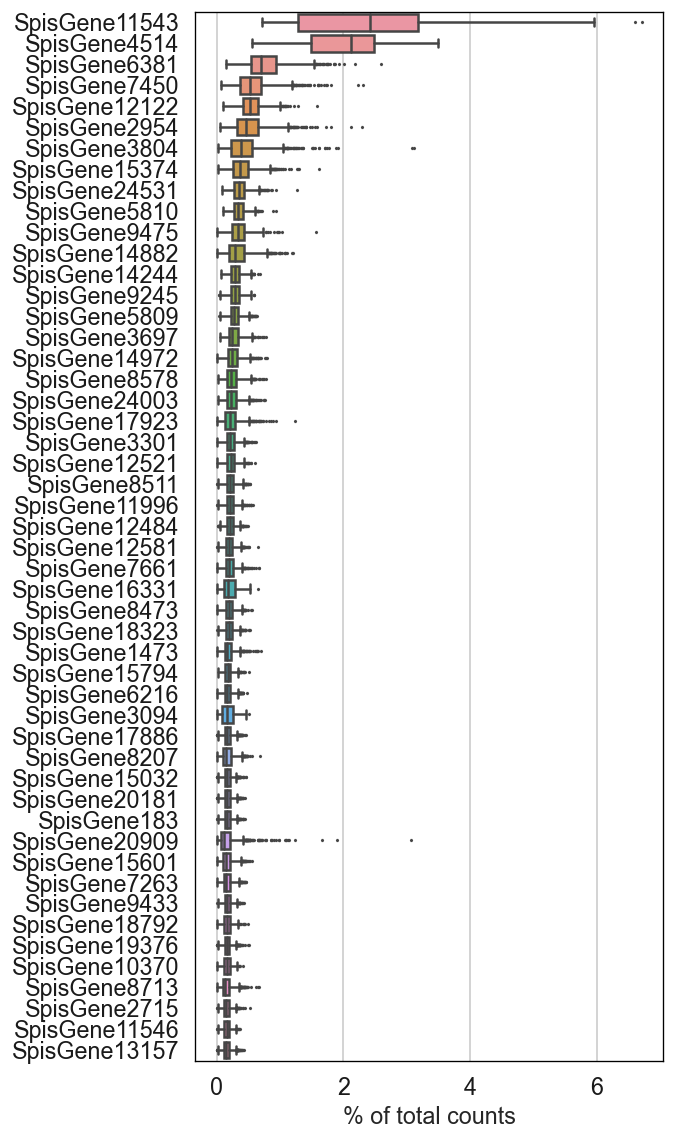

In [13]:
# Plotting percentage of counts per gene 
sc.pl.highest_expr_genes(adata, n_top=50)

In [14]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

adata.raw = adata

adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

In [15]:
# Correcting batch effet
sce.pp.harmony_integrate(adata,'sample',max_iter_harmony=20)

2023-01-26 15:59:13,246 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-01-26 15:59:13,500 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-01-26 15:59:13,503 - harmonypy - INFO - Iteration 1 of 20
2023-01-26 15:59:13,590 - harmonypy - INFO - Iteration 2 of 20
2023-01-26 15:59:13,647 - harmonypy - INFO - Iteration 3 of 20
2023-01-26 15:59:13,673 - harmonypy - INFO - Converged after 3 iterations


In [18]:
adata

AnnData object with n_obs × n_vars = 1200 × 5723
    obs: 'type', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'percent_mt2', 'n_counts', 'leiden'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'sample_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

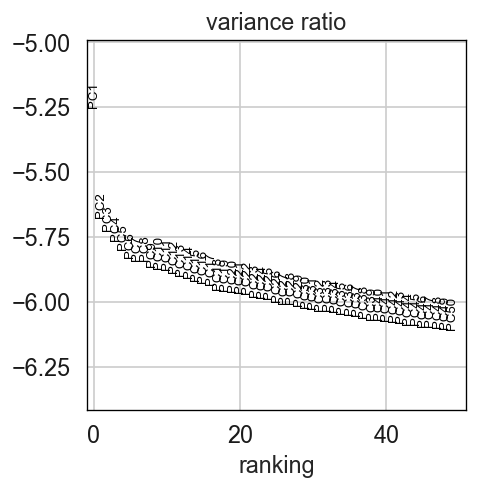

In [19]:
#plot the amount of variance explained by each PC
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

In [20]:
# Computing neighbors graph
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=22, knn=True, use_rep='X_pca_harmony')

# Clustering the graph using Leiden algorithm
sc.tl.leiden(adata,resolution=1) 

# Computing UMAP
sc.tl.umap(adata)

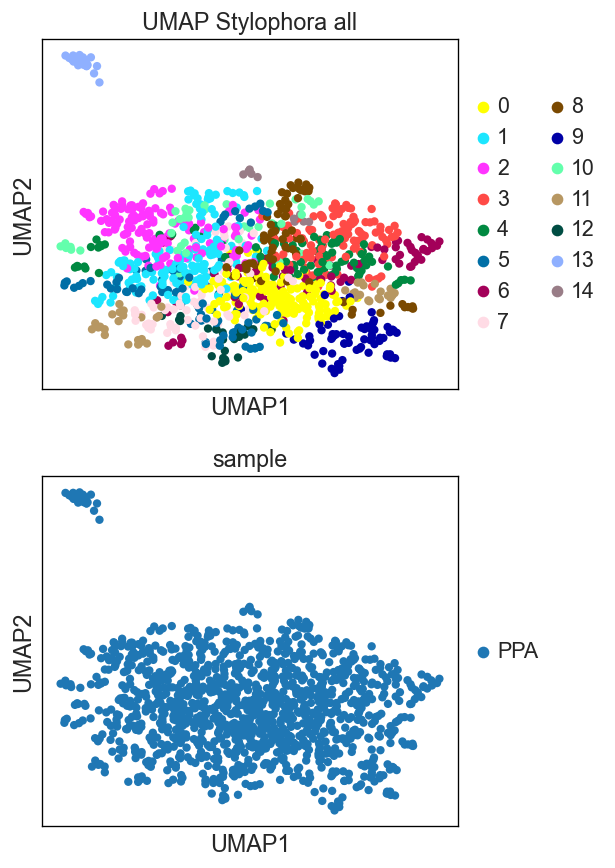

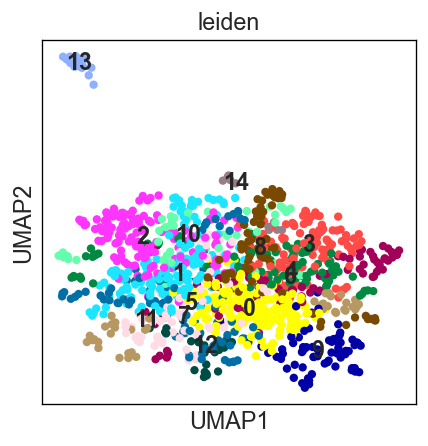

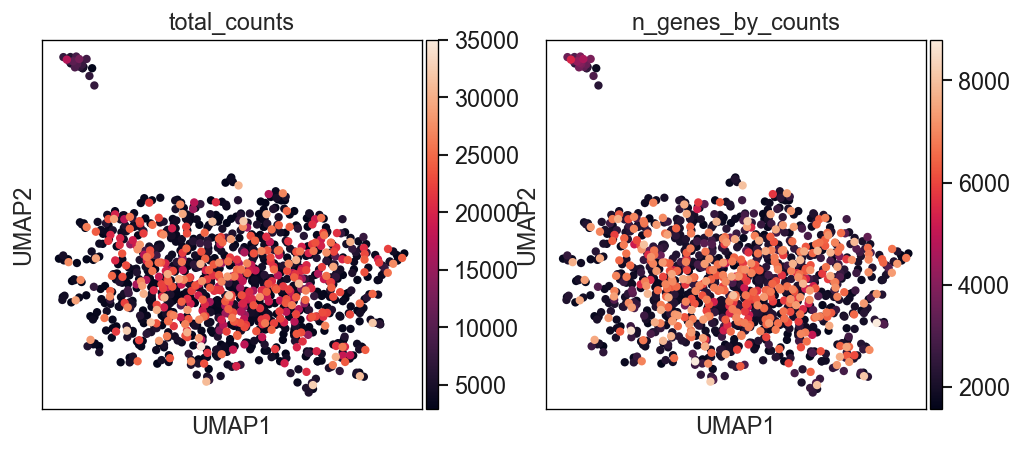

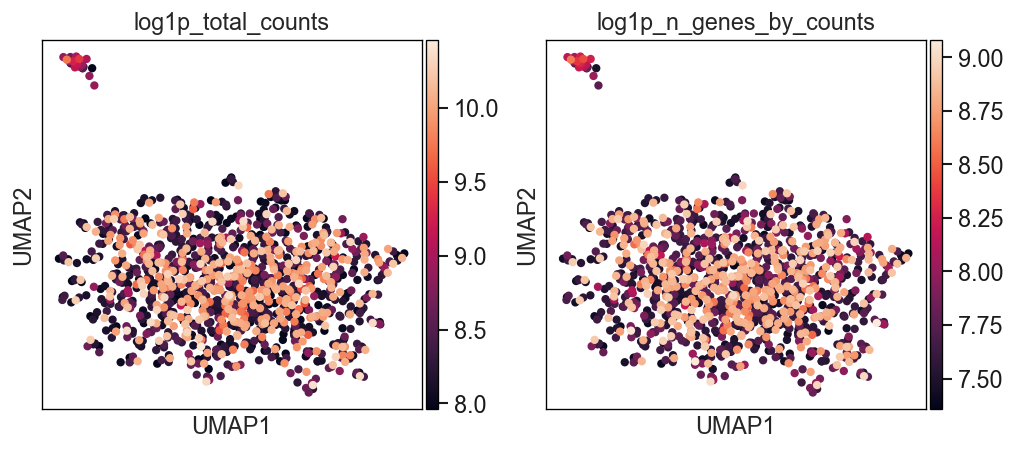

In [21]:
sc.pl.umap(adata, color=['leiden','sample'], title="UMAP Stylophora all",ncols=1)
sc.pl.umap(adata, color=['leiden'], legend_loc= 'on data')
sc.pl.umap(adata, color=['total_counts', 'n_genes_by_counts'])
sc.pl.umap(adata, color=['log1p_total_counts', 'log1p_n_genes_by_counts'])